### Установка и импорт необходимых пакетов

In [ ]:
!pip install -q pyLDAvis
!pip install -q pymorphy2

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pymorphy2
import pyLDAvis
import pyLDAvis.gensim_models
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
nltk.download('stopwords')
stop_words = stopwords.words('russian')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

### Обработка текста

In [ ]:
df = pd.read_csv('financial_review.csv')

In [ ]:
df.head(5)

,bank_href,login,review,bank_name,site,date,message_href,score,status,user_href
0,/kredit-evropa-bank.html,NaN,"Брал кредит в данной организации, после погаше...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
1,/kredit-evropa-bank.html,NaN,"В 2011 году,мною была оформлена мега карта в Т...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
2,/kredit-evropa-bank.html,NaN,С родителями увидели рекламу вклада Осеннее пр...,кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
3,/kredit-evropa-bank.html,NaN,Связать три года своей жизни с этим непорядочн...,кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
4,/kredit-evropa-bank.html,NaN,"Пользуюсь месяц карточкой Card Plus, сегодня п...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['bank_name'].value_counts()[:5]

втб              2603
сбербанк         2481
тинькофф банк    1476
почта банк       1264
альфа-банк       1260
Name: bank_name, dtype: int64

In [ ]:
df = df[df['bank_name'] == 'сбербанк'] # выбрал Сбербанк

In [ ]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [ ]:
def clean_text(text):
    text = re.sub(r"[^\w\s]", "", text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.parse(token)[0].normal_form for token in text.split(" ") if token.isalpha()]
    text = [word for word in text if not word in stop_words and lemmatizer.tag(word)[0].POS not in ('NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ')]
    return text

In [ ]:
df["processed_review"] = df["review"].apply(lambda x: clean_text(x))

In [ ]:
data = df["processed_review"].values.tolist()

In [ ]:
bigram = gensim.models.Phrases(data, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram) # построение модели биграмм

In [ ]:
data_words_bigrams = [bigram_mod[doc] for doc in data]

In [ ]:
id2word = corpora.Dictionary(data_words_bigrams) # словарь

texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts] # корпус

---

### Обучение LDA модели

Посмотрим, как изменяются значения метрик perplexity и coherence при изменении количества тем

In [ ]:
perplexity = []
coherence = []
for n_topics in range(1, 31):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    perplexity.append(lda_model.log_perplexity(corpus))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)

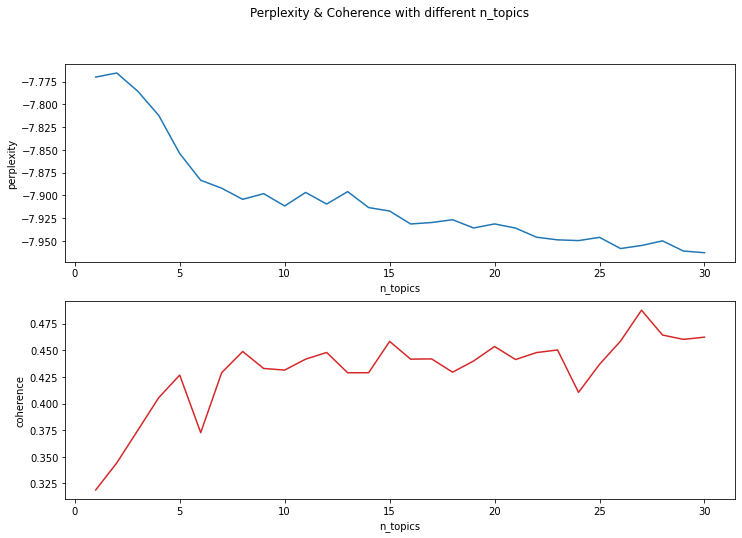

In [ ]:
fig, axs = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Perplexity & Coherence with different n_topics')
axs[0].plot(np.arange(1, 31), perplexity)
axs[1].plot(np.arange(1, 31), coherence, 'tab:red')
axs[0].set(xlabel='n_topics', ylabel='perplexity')
axs[1].set(xlabel='n_topics', ylabel='coherence')
plt.show()

In [ ]:
print(f'Наименьшее значение perplexity наблюдается при {perplexity.index(min(perplexity))} темах')

Наименьшее значение perplexity наблюдается при 29 темах


In [ ]:
print(f'Наибольшее значение coherence наблюдается при {coherence.index(max(coherence))} темах')

Наибольшее значение coherence наблюдается при 26 темах


В целом, значение метрики perplexity снижается более плавно при увеличении количества тем, но coherence выходит на плато раньше. Выберем n_topics = 8.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.028*"менеджер" + 0.022*"ипотека" + 0.020*"документ" + 0.018*"страховка" + '
  '0.015*"договор" + 0.015*"ипотечный" + 0.011*"наш" + 0.009*"квартира" + '
  '0.009*"сделка" + 0.009*"оформление"'),
 (1,
  '0.036*"сбербанк" + 0.033*"банк" + 0.021*"день" + 0.015*"который" + '
  '0.013*"заявление" + 0.012*"сотрудник" + 0.011*"ответ" + 0.010*"обратиться" '
  '+ 0.010*"деньга" + 0.009*"свой"'),
 (2,
  '0.030*"клиент" + 0.013*"очень" + 0.010*"сотрудник" + 0.010*"свой" + '
  '0.010*"человек" + 0.010*"вопрос" + 0.010*"сбер" + 0.009*"руководитель" + '
  '0.008*"обслуживание" + 0.008*"отношение"'),
 (3,
  '0.012*"июль" + 0.010*"исправить" + 0.009*"трубка" + 0.008*"график" + '
  '0.007*"центральный" + 0.007*"иметься" + 0.005*"окончание" + 0.004*"копия" + '
  '0.004*"пристав" + 0.004*"телефонный"'),
 (4,
  '0.093*"карта" + 0.043*"счёт" + 0.030*"деньга" + 0.024*"банк" + '
  '0.017*"перевод" + 0.013*"операция" + 0.012*"мобильный" + 0.012*"услуга" + '
  '0.011*"заблокировать" + 0.010*"снять"'),

Возможные интерпретации кластеров, судя по наиболее частым темам отзывов:

1. Ипотека
2. Обращение в отделение Сбербанка
3. Оценка качества обслуживания
4. Звонок в отделение банка с претензией
5. Дебетовая карта
6. Посещение отделения банка
7. Пользование банкоматом
8. Кредит

In [ ]:
# perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence: ', coherence_lda)


Perplexity:  -7.904294074190421

Coherence:  0.44889652037242334


In [ ]:
# визуализация тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.059729 -0.229695       1        1   8.385230
1     -0.264437  0.040523       2        1  31.957212
2      0.029526 -0.166527       3        1   6.677005
3      0.224626 -0.018364       4        1   2.956140
4     -0.010080  0.210254       5        1   9.780726
5     -0.259299 -0.035129       6        1  26.703979
6      0.139937  0.176397       7        1   5.844038
7      0.079998  0.022540       8        1   7.695670, topic_info=            Term         Freq        Total Category  logprob  loglift
21         карта  3332.000000  3332.000000  Default  30.0000  30.0000
10        деньга  2298.000000  2298.000000  Default  29.0000  29.0000
420       кредит  1285.000000  1285.000000  Default  28.0000  28.0000
201         счёт  1323.000000  1323.000000  Default  27.0000  27.0000
210     банкомат   605.000000   605.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
0           банк   279.329147  4132.997524   Topic8  -4.0362  -0.1299
446       платёж   114.207167   545.433913   Topic8  -4.9306   1.0009
275     оформить    90.746984   390.221982   Topic8  -5.1605   1.1059
1578  зарплатный    68.148057   132.334484   Topic8  -5.4469   1.9009
1764       отказ    66.042981   191.656767   Topic8  -5.4783   1.4991

[472 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
767       5  0.967756  автоплатёж
2771      1  0.989897       акция
1537      8  0.984689      апрель
1162      5  0.972353       арест
50        5  0.970119      баланс
...     ...       ...         ...
2342      7  0.954439       экран
2770      1  0.970800       юрист
1098      5  0.195926      январь
1098      7  0.195926      январь
1098      8  0.601772      январь

[708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

---

### Проверка зависимости Score от темы отзыва

Сначала создадим новый датасет с двумя колонками: score и topic.

In [ ]:
topic_score = df[df['bank_name']=='сбербанк'][['score']].copy()

In [ ]:
amount_of_review = df[df['bank_name']=='сбербанк'].shape[0]

In [ ]:
topics = []
for review_n in range(amount_of_review):
    review = lda_model.get_document_topics(corpus[review_n])
    topic, _ = max(review, key=lambda x:x[1]) # для каждого отзыва берем тему с наибольшей вероятностью
    topics.append(topic)

In [ ]:
topic_score['topic'] = topics

In [ ]:
topic_score = topic_score.replace('Без оценки', np.nan)
topic_score.dropna(inplace=True) # избавляемся от NaN

In [ ]:
topic_score.head(5)

,score,topic
10116,1,7
10117,1,1
10118,5,0
10119,1,1
10120,1,1


Далее, применим критерий Хи-квадрат для проверки зависимости двух величин

In [ ]:
contingency_tb = pd.crosstab(topic_score['topic'], topic_score['score']) # таблица частот

In [ ]:
contingency_tb

score,1,2,3,4,5
topic,,,,,
0,33,7,4,1,134
1,552,82,19,7,27
2,31,4,2,1,45
3,8,2,0,2,4
4,70,7,6,0,1
5,414,67,25,12,80
6,49,5,4,1,3
7,60,11,6,0,5


In [ ]:
import scipy

Нулевая гипотеза: score и topic независимы друг от друга

$\alpha$ = 0.05

In [ ]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_tb) # рассчитываем chi2

In [ ]:
print(f"значение chi2:     {chi2_stat:.5g}")
print(f"p-value:           {p:.5g}")
print(f"степени свободы:   {dof}")

значение chi2:     668.64
p-value:           6.9693e-123
степени свободы:   28


Полученное значение критерия превышает табличное (*16.928*). Нулевая гипотеза отклоняется. Таким образом, взаимосвязь topic и score присутствует. Из таблицы видно, что, например, отзывы про ипотеку имеют более положительный эмоциональный окрас, нежели отзывы про обращение или посещение отделения банка.